In [1]:
import numpy as np
import torch
import pandas as pd
from tqdm.auto import tqdm
import pickle
import copy
import sys
from os import path
import matplotlib.pyplot as plt
from factor_analyzer import FactorAnalyzer, Rotator
from joblib import Parallel, delayed
from matplotlib.colors import LinearSegmentedColormap
from sklearn.decomposition import PCA
from sklearn.linear_model import LinearRegression
from sloth import *
from definitions import *

device = 'cpu'
d=3 #Sloth dimensions

colors = ["blue", "white", "red"]#, "black"
colormap = "coolwarm" #LinearSegmentedColormap.from_list("GreenRed", colors)

Loading and prepating data

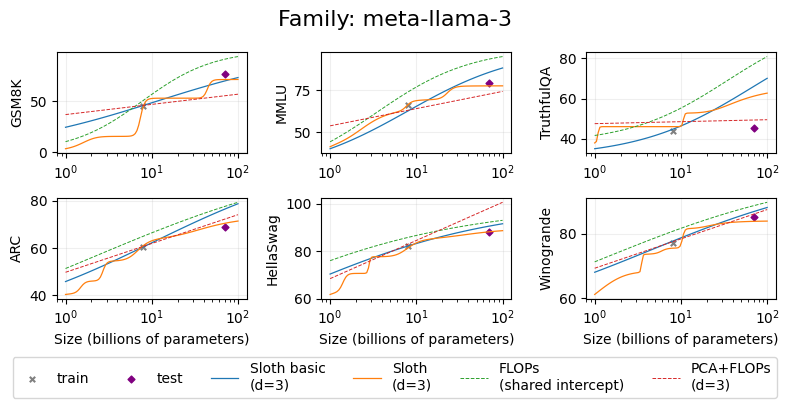

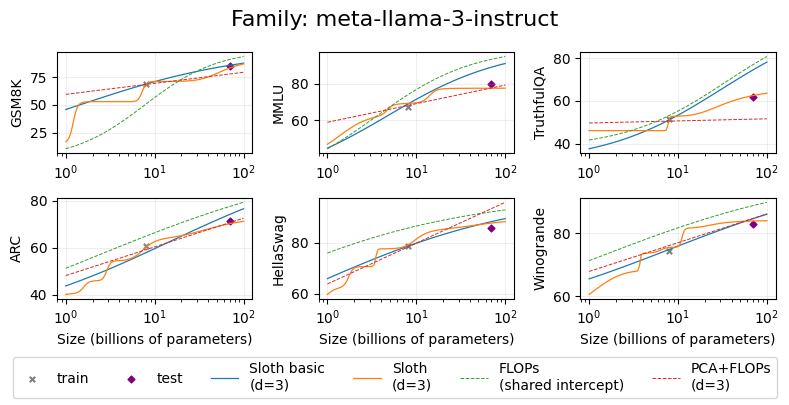

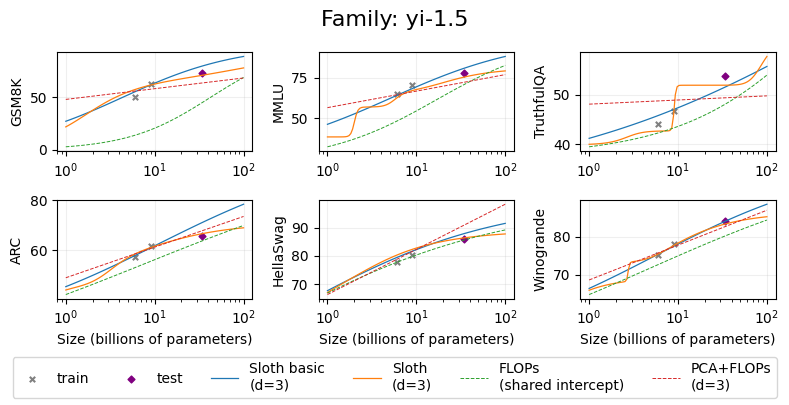

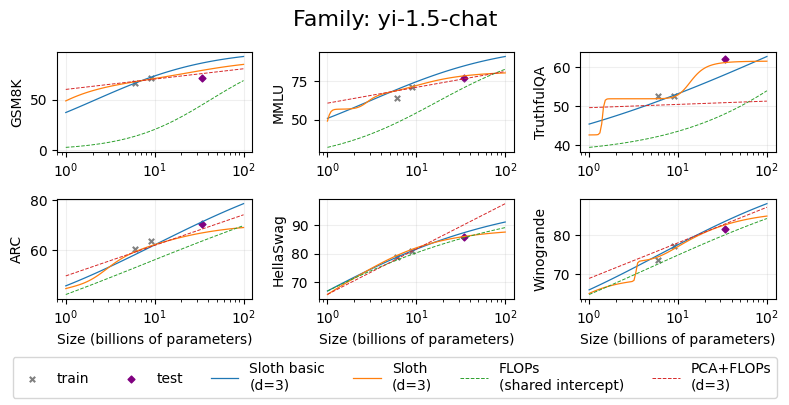

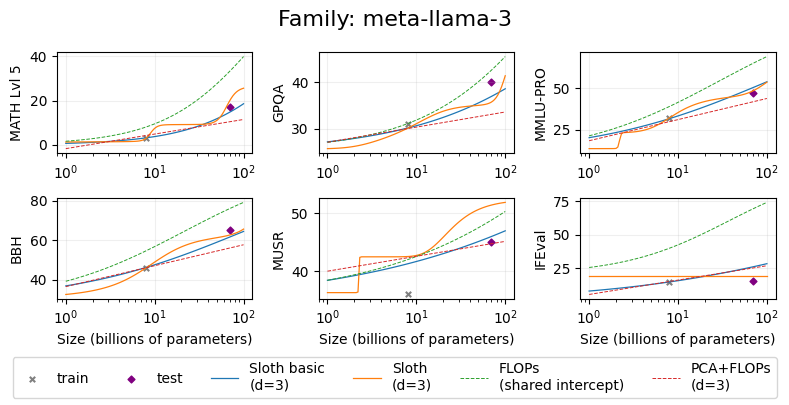

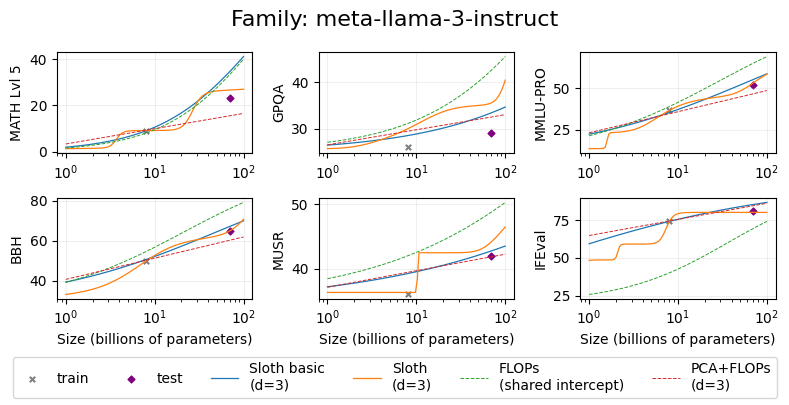

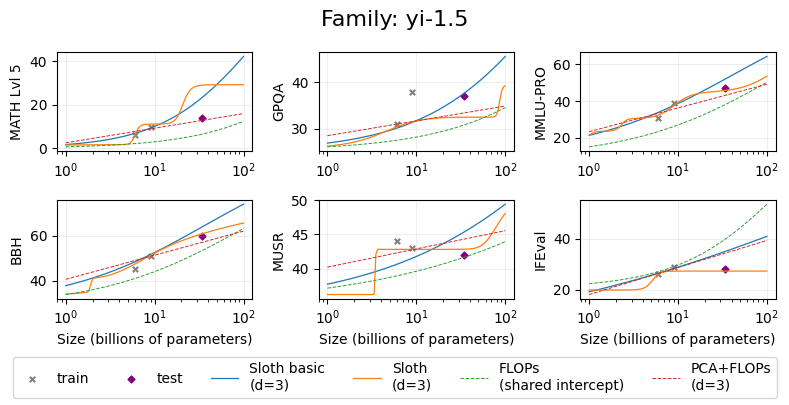

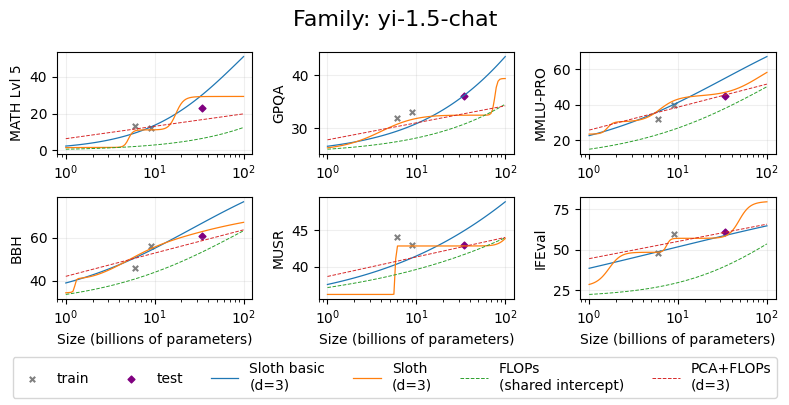

In [3]:
Y_names_list = [['GSM8K',
                'MMLU',
                'TruthfulQA',
                'ARC',
                'HellaSwag',
                'Winogrande'],
                ['MATH Lvl 5',
                 'GPQA',
                 'MMLU-PRO',
                 'BBH',
                 'MUSR',
                 'IFEval']]

for lb,Y_names in enumerate(Y_names_list):
    data = pd.read_csv('../data/data_v2.csv')
    data['logS'] = np.log10(data['#Params (B)'])
    data['logT'] = np.log10(data['Pretraining Data Size (T)'])
    data['logSlogT'] = data['logS']*data['logT']
    data['GreatFamily'] = data['Family']
    data['Family'] = data['Family2']
    X_names = ['logS','logT','logSlogT'] 
    
    data = data.loc[:,['Model','Family','GreatFamily','Instruct']+X_names+Y_names].dropna()
    data.head()
    
    for num_training_models in [1,2]:
    
        if num_training_models == 2:
            test_families = ['yi-1.5',
                             'yi-1.5-chat']
            test_models = [['yi-1.5-34b'],
                           ['yi-1.5-34b-chat']]
            models_to_delete = [['yi-1.5-34b', 'yi-1.5-34b-chat', 'blossom-v5.1-34b', 'dolphin-2.9.1-yi-1.5-34b'],
                                ['yi-1.5-34b', 'yi-1.5-34b-chat', 'blossom-v5.1-34b', 'dolphin-2.9.1-yi-1.5-34b']]
        else:
            test_families = ['meta-llama-3',
                             'meta-llama-3-instruct']
            test_models = [['meta-llama-3-70b'],
                           ['meta-llama-3-70b-instruct']]
            models_to_delete = [['meta-llama-3-70b', 'meta-llama-3-70b-instruct'],
                                ['meta-llama-3-70b', 'meta-llama-3-70b-instruct']]
            
        for i in range(len(test_families)):    
            # data
            data_train = data.loc[[m not in models_to_delete[i] for m in data.Model]]
            data_test = data.loc[[m in test_models[i] for m in data.Model]]
            
            X_train = np.array(data_train.loc[:,X_names]).astype(float)
            Y_train = np.array(data_train.loc[:,Y_names]).astype(float)
            families = pd.get_dummies(np.array(data_train.Family))
            D_train = np.array(families).astype(float)
            
            ind_family = int(np.argmax(families.columns == test_families[i])) #
            ind_family2 = D_train[:,ind_family]==1
            X_test = np.array(data_test.loc[:,X_names]).astype(float)
            Y_test = np.array(data_test.loc[:,Y_names]).astype(float)
            D_test = np.zeros((X_test.shape[0],D_train.shape[1]))
            D_test[:,ind_family] = 1
            
            F_train = (np.log10(6)+X_train[:,0]+X_train[:,1])[:,None]
            F_test = (np.log10(6)+X_test[:,0]+X_test[:,1])[:,None]
            I_train = np.ones((D_train.shape[0],1))
            I_test = np.ones((D_test.shape[0],1))
            
            Cs = []
            for s in Y_names:
                Cs.append(lower_bounds[s])
            Cs = np.array(Cs).astype(float)[None,:]
            
            # Training models
            model_owen = Sloth(d)
            model_owen.fit(F_train, I_train, Y_train, Cs, fit_C=True, train_link=False, positive_w=False, verbose=False)
            
            model_logistic = Sloth(d)
            model_logistic.fit(X_train, D_train, Y_train, Cs, fit_C=False, train_link=False, positive_w=False, verbose=False)
            
            model_nn = Sloth(d)
            model_nn.fit(X_train, D_train, Y_train, Cs, fit_C=True, train_link=True, positive_w=False, verbose=False)
            
            pca = PCA(n_components=d)
            pca.fit(Y_train)
            pca_reg = LinearRegression(fit_intercept=False).fit(np.hstack((F_train, D_train)), pca.transform(Y_train))
            
            # Plotting
            ncols = 3
            nrows = int(np.ceil(len(Y_names) / ncols))  # Calculate rows to fit all plots
            
            fig, axes = plt.subplots(nrows, ncols, figsize=(8, 4))  # Create a grid of subplots
            fig.suptitle(f"Family: {test_families[i]}", fontsize=16)  # Global title
            
            axes = axes.flatten()  # Flatten axes array for easy indexing if more than one row
            
            for ind_bench, ax in enumerate(axes[:len(Y_names)]):  # Loop only over required axes
                tokens = X_train[ind_family2][0, 1]
                X_plot = np.linspace(0, np.log10(100), 100).reshape(-1, 1)
                X_plot = np.hstack((X_plot, tokens * np.ones(X_plot.shape), tokens * X_plot))
                D_plot = np.zeros((X_plot.shape[0], D_train.shape[1]))
                D_plot[:, ind_family] = 1
                F_plot = (np.log10(6)+X_plot[:,0]+X_plot[:,1])[:,None]
                I_plot = np.ones((D_plot.shape[0],1))
            
                ax.scatter(10**X_train[ind_family2, 0], 100*Y_train[ind_family2, ind_bench], color='gray', s=15, marker='x', label='train')
                ax.scatter(10**X_test[:, 0], 100*Y_test[:, ind_bench], color='purple', s=12, marker='D', label='test')
                ax.plot(10**X_plot[:, 0], 100*model_logistic.predict(X_plot, D_plot)[:, ind_bench], lw=.9, label=f'Sloth basic\n(d={d})')
                ax.plot(10**X_plot[:, 0], 100*model_nn.predict(X_plot, D_plot)[:, ind_bench], lw=.9, label=f'Sloth\n(d={d})')
                ax.plot(10**X_plot[:, 0], 100*model_owen.predict(F_plot, I_plot)[:, ind_bench], ls='--', lw=.7, label='FLOPs\n(shared intercept)')
                ax.plot(10**X_plot[:, 0], 100*pca.inverse_transform(pca_reg.predict(np.hstack((F_plot, D_plot))))[:,ind_bench], ls='--', lw=.7, label=f'PCA+FLOPs\n(d={d})')
                
                
                if ind_bench >= ncols:  # Remove x-labels for the top row
                    ax.set_xlabel("Size (billions of parameters)")
                else:
                    ax.set_xlabel("")
            
                ax.set_xscale('log', base=10)
                ax.set_ylabel(f"{Y_names[ind_bench]}")
                ax.grid(alpha=0.2)
            
            # Hide any extra unused subplots if `len(Y_names)` is not a multiple of ncols
            for ax in axes[len(Y_names):]:
                ax.set_visible(False)
            
            # Add a unified legend below the plots
            handles, labels = axes[0].get_legend_handles_labels()  # Get legend items from one subplot
            fig.legend(handles, labels, loc="lower center", ncol=len(labels))  # Place legend below figure
            
            plt.tight_layout(rect=[0, 0.1, 1, 1])  # Adjust layout to fit the global title and legend
            plt.savefig(f'../plots/link_functions_lb-{lb}_family-{test_families[i]}.pdf', bbox_inches='tight', dpi=400, transparent=False)
            plt.show()